In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 2
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [9]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [10]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [11]:
# # Review unperturbed elements
# elts_ast

In [12]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                file_name=f'candidate_elt_pert_large_{random_seed:04d}.h5',
                name='model')

In [31]:
# model.load()

In [32]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     0.08  :   0.00 :  1800.46 :  7200.00
Mean     :     0.08  :   0.00 :  1800.46 :  7200.00
Median   :    -0.05  :   0.00 :  1807.21 :  7200.00
GeoMean  :     1.07  :   0.00 :  1800.45 :  7200.99
Min      :    -1.14  :   0.00 :  1792.81 :  7200.00
Max      :     3.51  :   0.00 :  1807.22 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


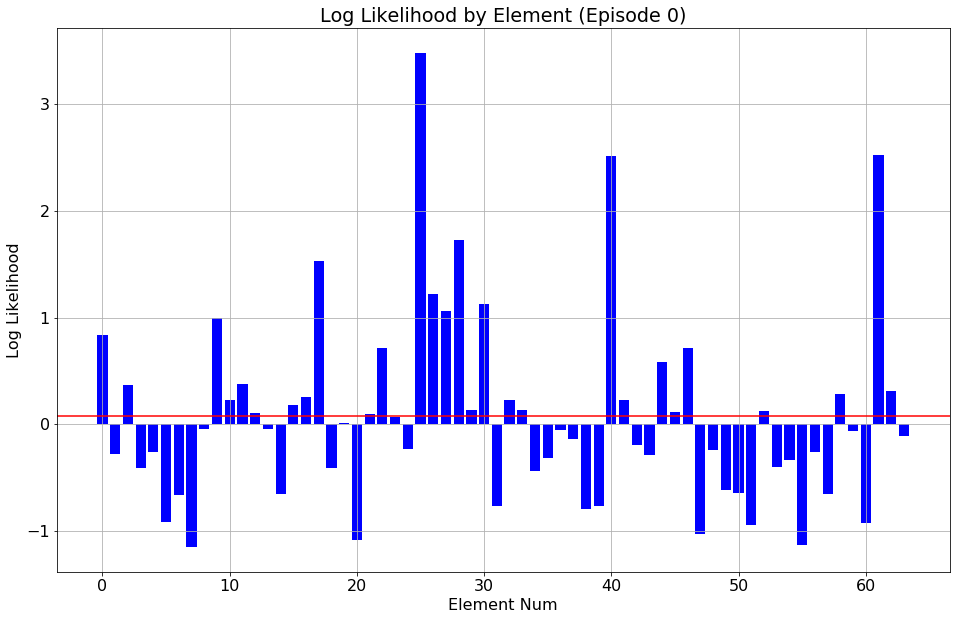

In [33]:
fig, ax = model.plot_bar('log_like', sorted=False)

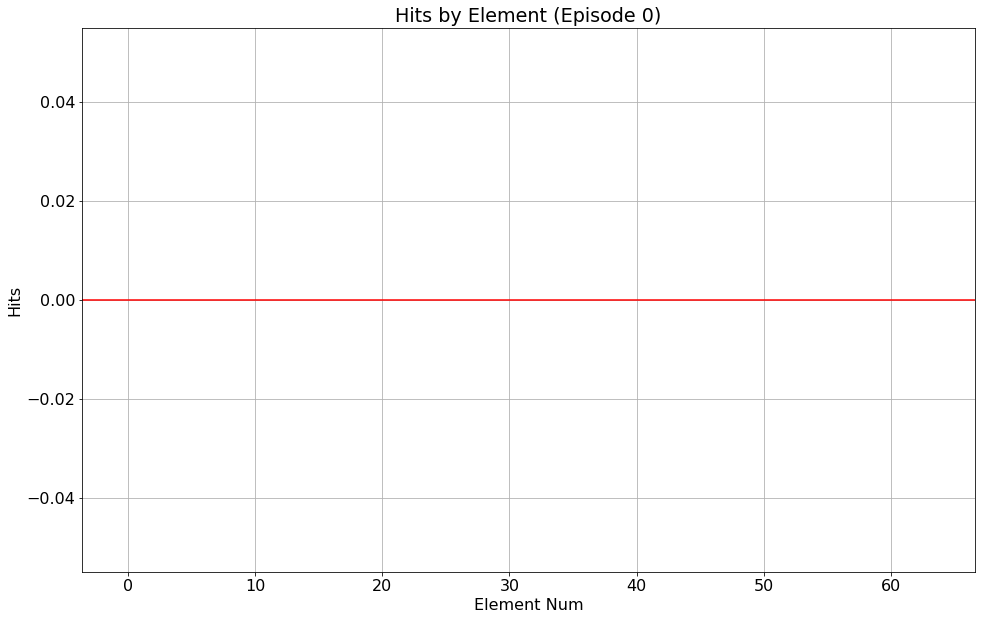

In [34]:
fig, ax = model.plot_bar('hits', sorted=False)

In [35]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 4096 samples
Epoch 1/4
4096/4096 [==============================] - 4s 929us/sample - loss: -4.5985
Epoch 2/4
4096/4096 [==============================] - 2s 403us/sample - loss: -9.7914
Epoch 3/4
4096/4096 [==============================] - 2s 406us/sample - loss: -15.6093
Epoch 4/4
4096/4096 [==============================] - 2s 412us/sample - loss: -22.0440
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1739.15 :  1739.15 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      0.97 :     0.97 :      nan
Mean Hits           :      0.00 :     0.00 : 

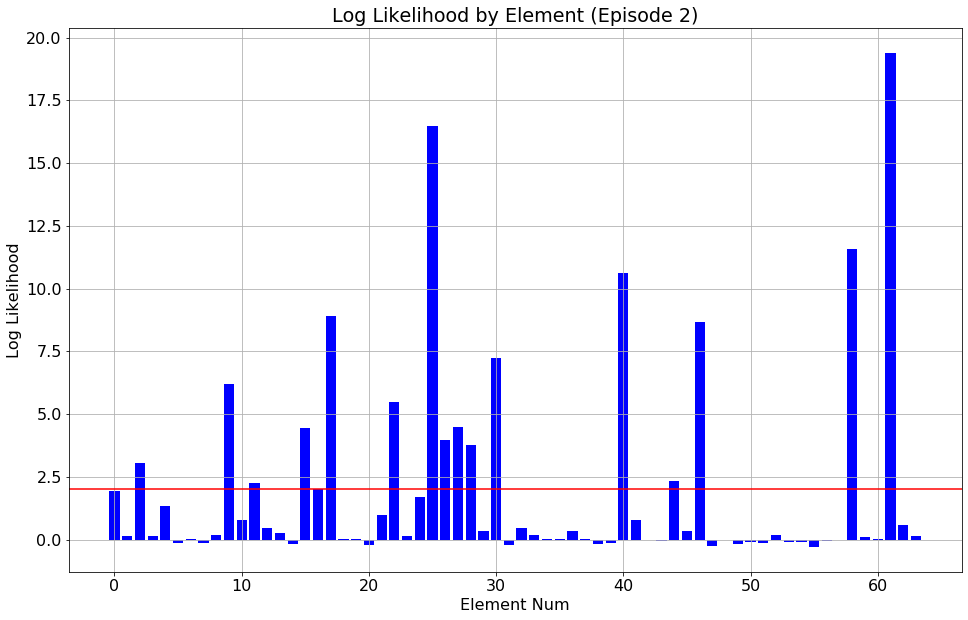

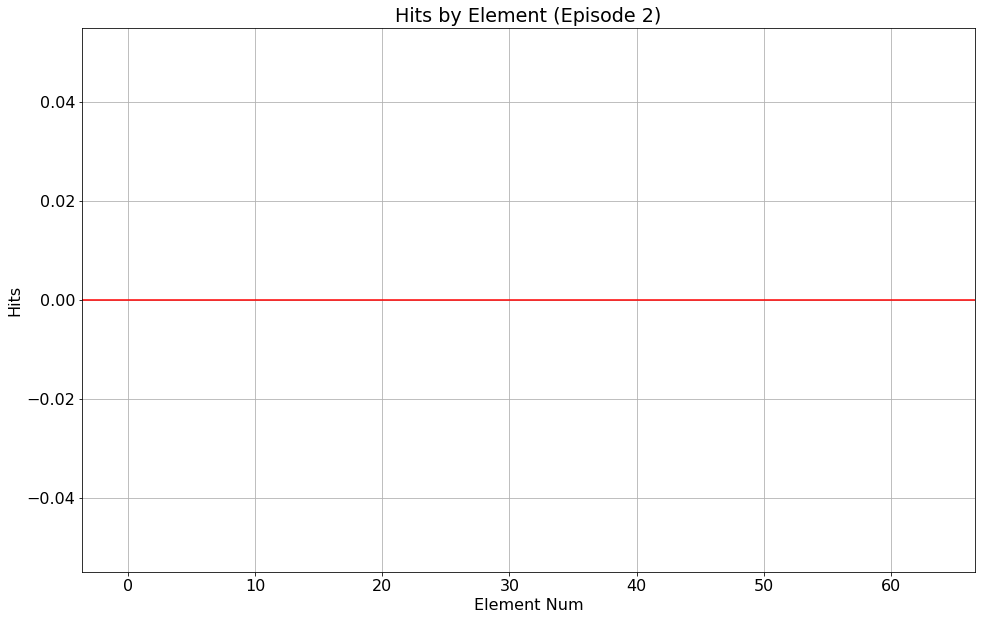


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 2: Epoch    8, Batch    512
effective_learning_rate=2.441e-04, training_time 25 sec.
Train on 4096 samples
Epoch 9/12
4096/4096 [==============================] - 5s 1ms/sample - loss: -145.6873
Epoch 10/12
4096/4096 [==============================] - 2s 492us/sample - loss: -188.0134
Epoch 11/12
4096/4096 [==============================] - 2s 494us/sample - loss: -204.1659
Epoch 12/12
4096/4096 [==============================] - 2s 489us/sample - loss: -214.4161
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:   1609.57 :  1609.57 :      nan arc seconds
Geom Mean Threshold :   7200.00 :  7200.00 :      nan arc seconds
Mean Log Likelihood :      8.00 :     8.00 : 

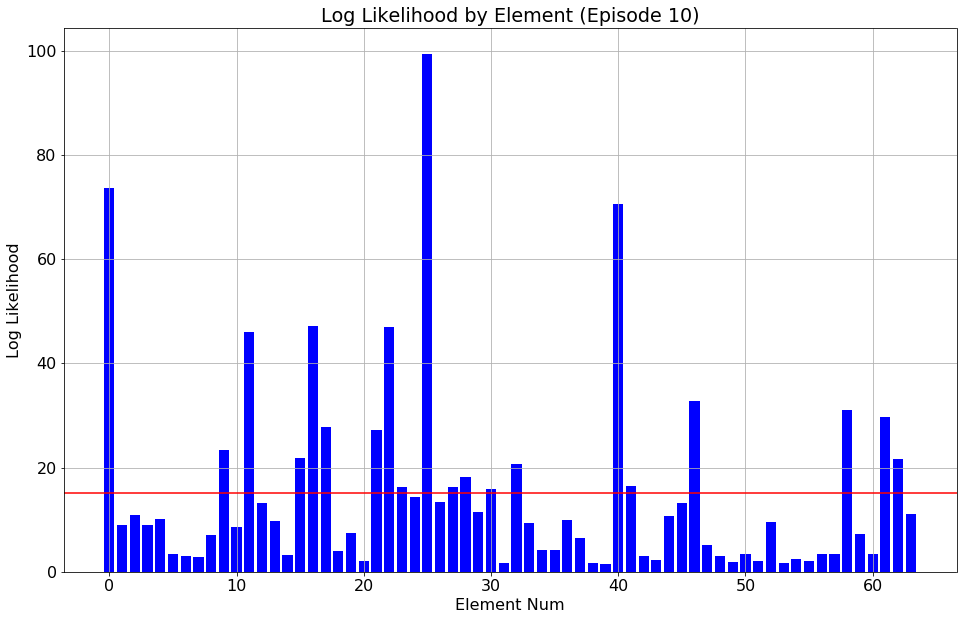

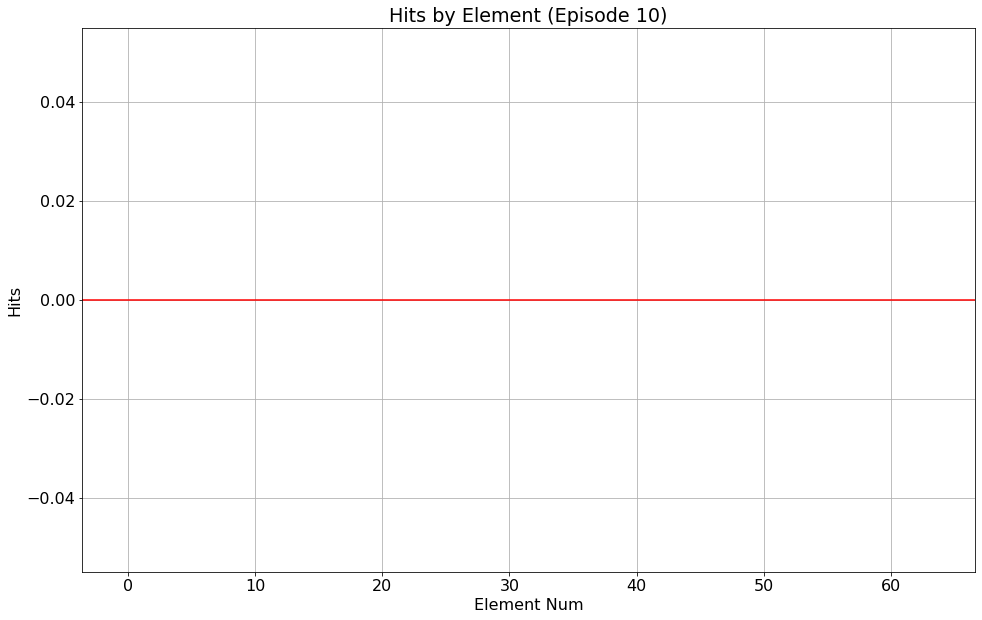


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************

Training episode 10: Epoch   40, Batch   2560
effective_learning_rate=2.441e-04, training_time 106 sec.
Train on 4096 samples
Epoch 41/44
4096/4096 [==============================] - 4s 913us/sample - loss: -322.6169
Epoch 42/44
4096/4096 [==============================] - 2s 403us/sample - loss: -395.9469
Epoch 43/44
4096/4096 [==============================] - 2s 407us/sample - loss: -482.8219
Epoch 44/44
4096/4096 [==============================] - 2s 413us/sample - loss: -584.5561
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    766.31 :   766.31 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      nan arc seconds
Mean Log Likelihood :     23.75 :    23.75 :      nan
Mean Hits           :      0

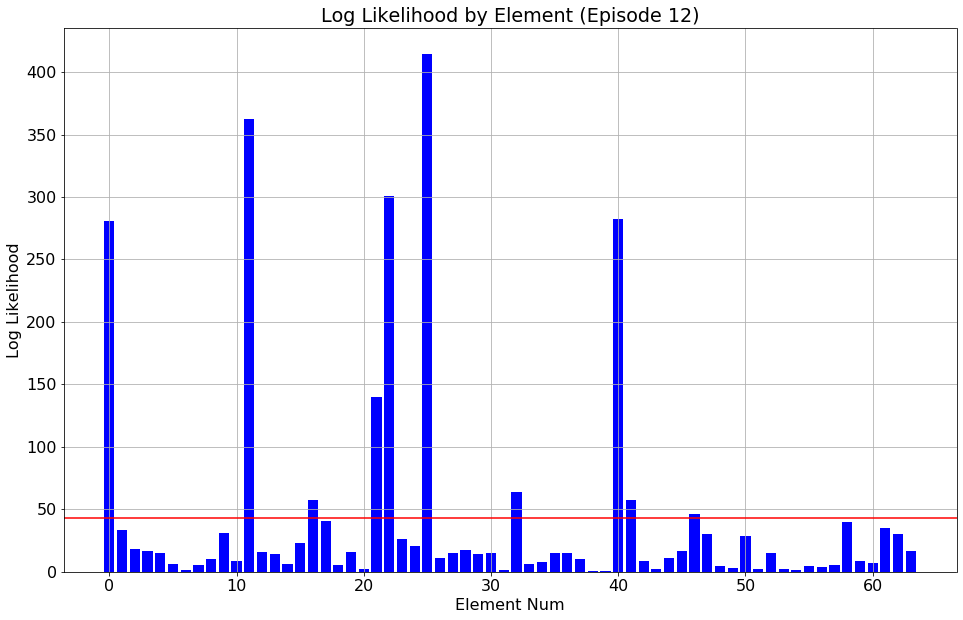

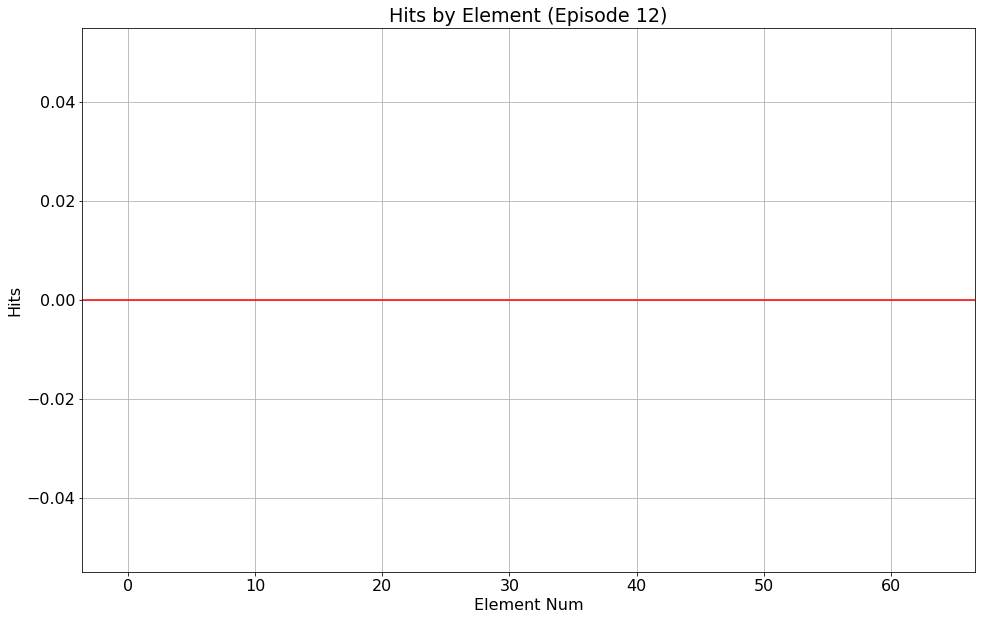


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 12: Epoch   48, Batch   3072
effective_learning_rate=2.441e-04, training_time 125 sec.
Train on 4096 samples
Epoch 49/52
4096/4096 [==============================] - 5s 1ms/sample - loss: -1345.3545
Epoch 50/52
4096/4096 [==============================] - 2s 510us/sample - loss: -1409.8885
Epoch 51/52
4096/4096 [==============================] - 2s 516us/sample - loss: -1438.3227
Epoch 52/52
4096/4096 [==============================] - 2s 499us/sample - loss: -1461.4677
                    \  All Elts : Bad Elts : Good Elts (0)
Geom Mean Resolution:    564.14 :   564.14 :      nan arc seconds
Geom Mean Threshold :   5400.00 :  5400.00 :      nan arc seconds
Mean Log Likelihood :     52.90 :    5

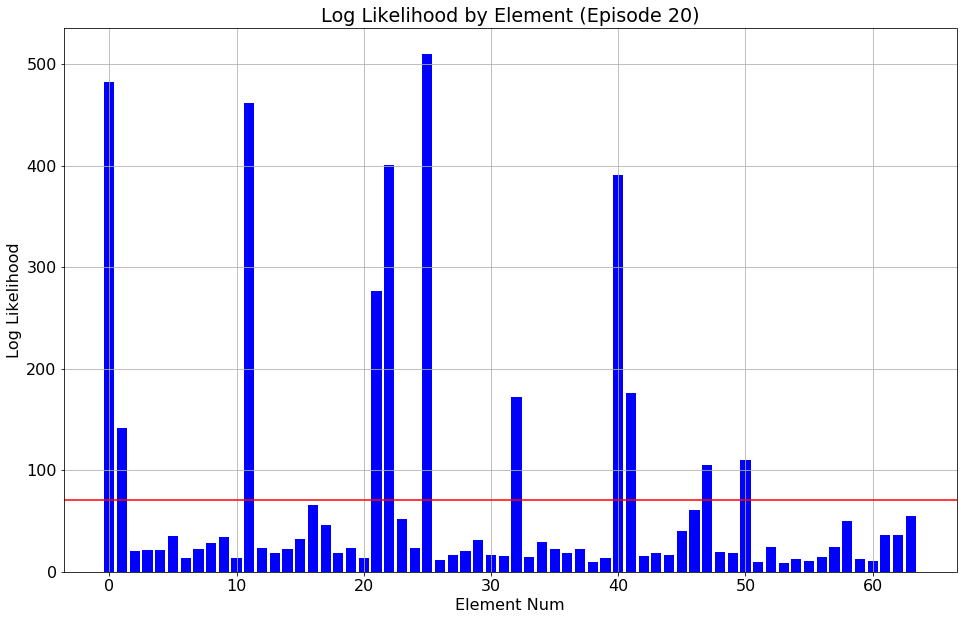

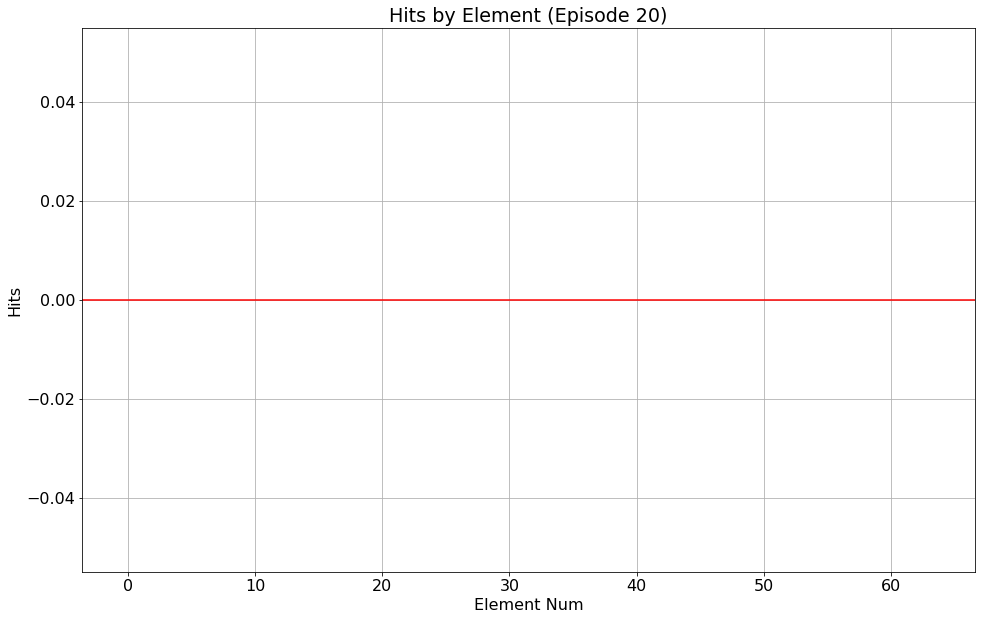


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************

Training episode 20: Epoch   80, Batch   5120
effective_learning_rate=2.441e-04, training_time 211 sec.
Train on 4096 samples
Epoch 81/84
4096/4096 [==============================] - 4s 973us/sample - loss: -1788.7533
Epoch 82/84
4096/4096 [==============================] - 2s 446us/sample - loss: -1995.6509
Epoch 83/84
4096/4096 [==============================] - 2s 424us/sample - loss: -2211.7709
Epoch 84/84
4096/4096 [==============================] - 2s 441us/sample - loss: -2434.5929
                    \  All Elts : Bad Elts : Good Elts (1)
Geom Mean Resolution:    341.18 :   348.50 :    89.44 arc seconds
Geom Mean Threshold :   3600.00 :  3600.00 :  3600.00 arc seconds
Mean Log Likelihood :     92.10 :    82.99 :   665.98
Mean Hits           :   

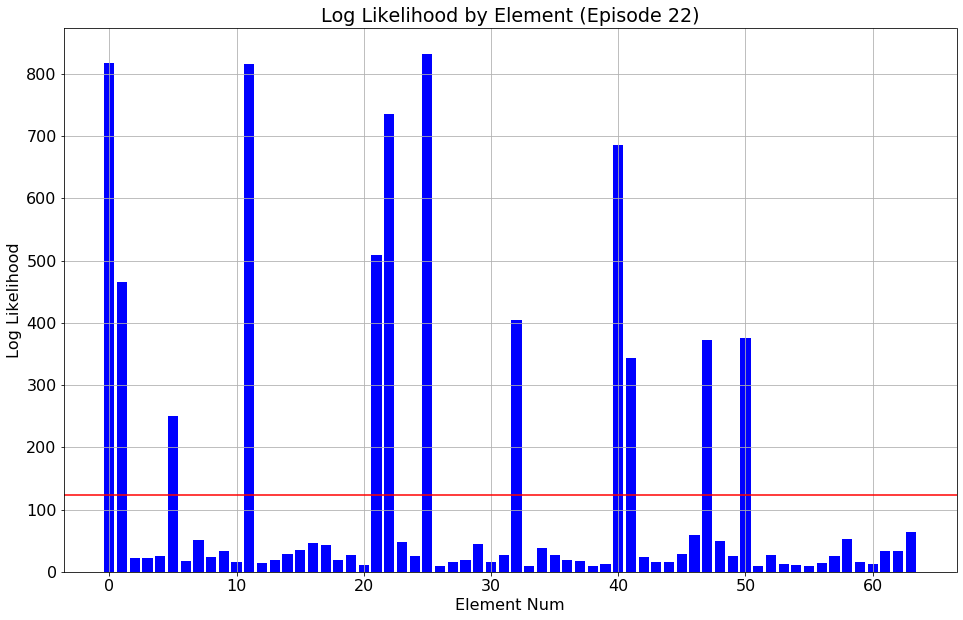

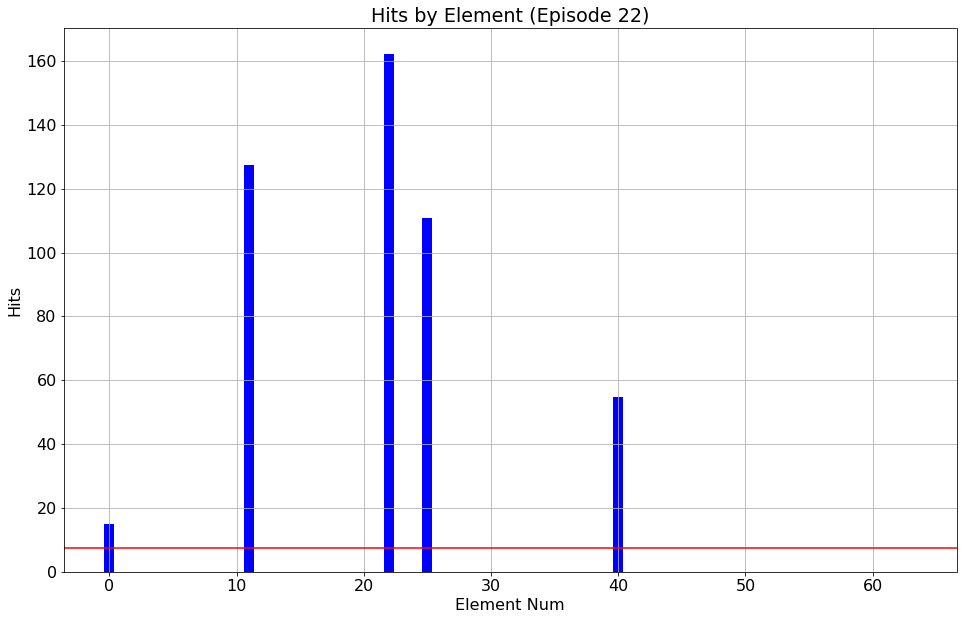


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 22: Epoch   88, Batch   5632
effective_learning_rate=2.365e-04, training_time 230 sec.
Train on 4096 samples
Epoch 89/92
4096/4096 [==============================] - 6s 1ms/sample - loss: -3468.6318
Epoch 90/92
4096/4096 [==============================] - 2s 548us/sample - loss: -3540.5769
Epoch 91/92
4096/4096 [==============================] - 2s 564us/sample - loss: -3562.3277
Epoch 92/92
4096/4096 [==============================] - 2s 559us/sample - loss: -3584.3319
Adjusted element weight down on 7 candidate elements. Mean weight = 9.11e-01
                    \  All Elts : Bad Elts : Good Elts (5)
Geom Mean Resolution:    290.29 :   333.26 :    56.93 arc seconds
Geom Mean Threshold :   360

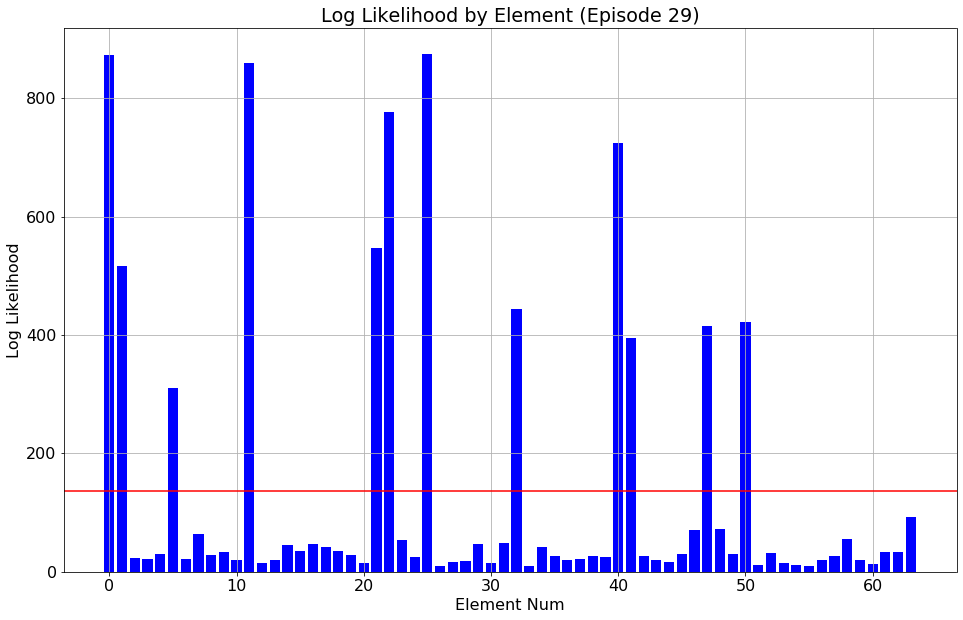

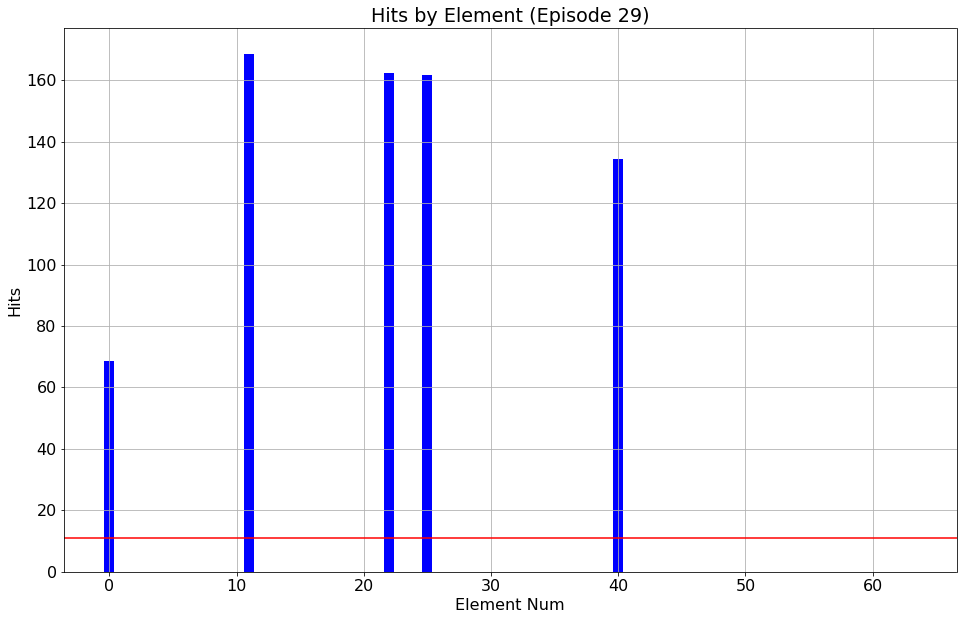


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************

Training episode 29: Epoch  116, Batch   7424
effective_learning_rate=2.441e-04, training_time 311 sec.
Train on 4096 samples
Epoch 117/120
4096/4096 [==============================] - 4s 994us/sample - loss: -3651.1503
Epoch 118/120
4096/4096 [==============================] - 2s 475us/sample - loss: -3861.8155
Epoch 119/120
4096/4096 [==============================] - 2s 483us/sample - loss: -4065.2176
Epoch 120/120
4096/4096 [==============================] - 2s 477us/sample - loss: -4263.0388
                    \  All Elts : Bad Elts : Good Elts (5)
Geom Mean Resolution:    232.41 :   273.93 :    33.42 arc seconds
Geom Mean Threshold :   2400.00 :  2400.00 :  2400.00 arc seconds
Mean Log Likelihood :    155.50 :    87.91 :   953.03
Mean Hits       

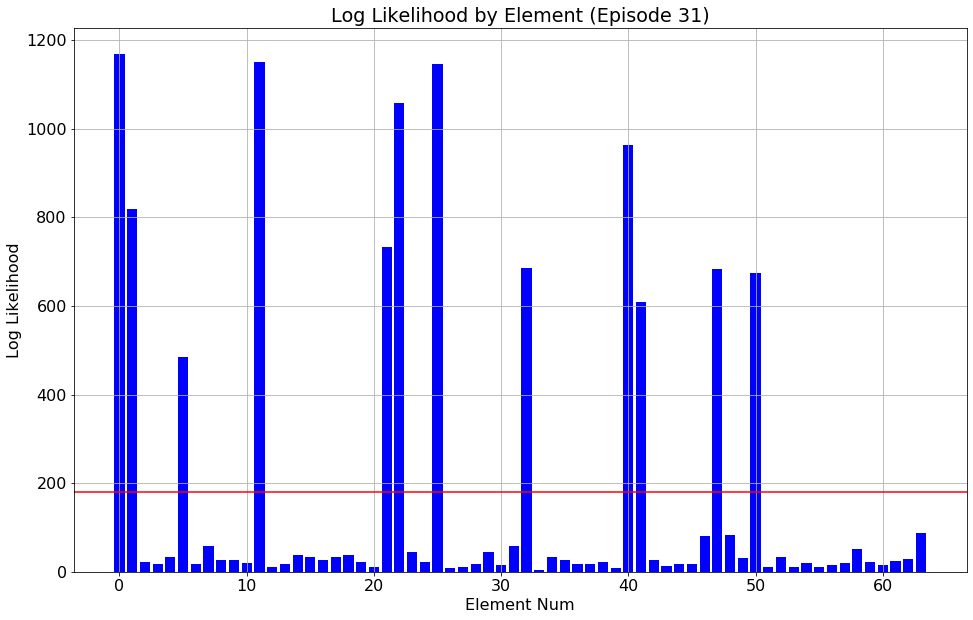

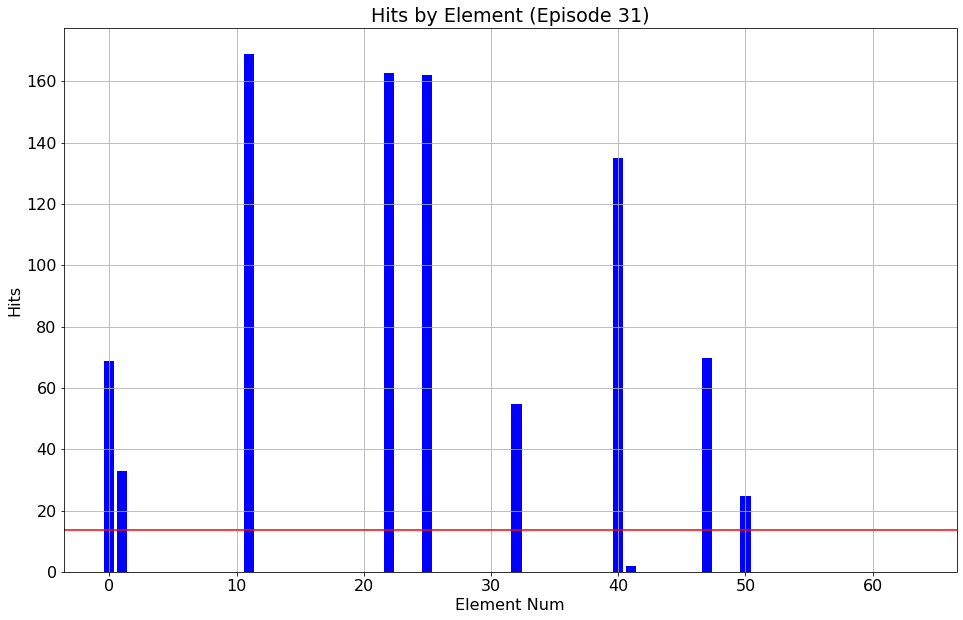


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 31: Epoch  124, Batch   7936
effective_learning_rate=2.213e-04, training_time 332 sec.
Train on 4096 samples
Epoch 125/128
4096/4096 [==============================] - 5s 1ms/sample - loss: -4391.2458
Epoch 126/128
4096/4096 [==============================] - 2s 582us/sample - loss: -4585.4181
Epoch 127/128
4096/4096 [==============================] - 2s 564us/sample - loss: -4603.4387
Epoch 128/128
4096/4096 [==============================] - 2s 592us/sample - loss: -4621.5015
Adjusted element weight down on 64 candidate elements. Mean weight = 4.86e-02
                    \  All Elts : Bad Elts : Good Elts (9)
Geom Mean Resolution:    211.90 :   285.61 :    34.18 arc seconds
Geom Mean Threshol

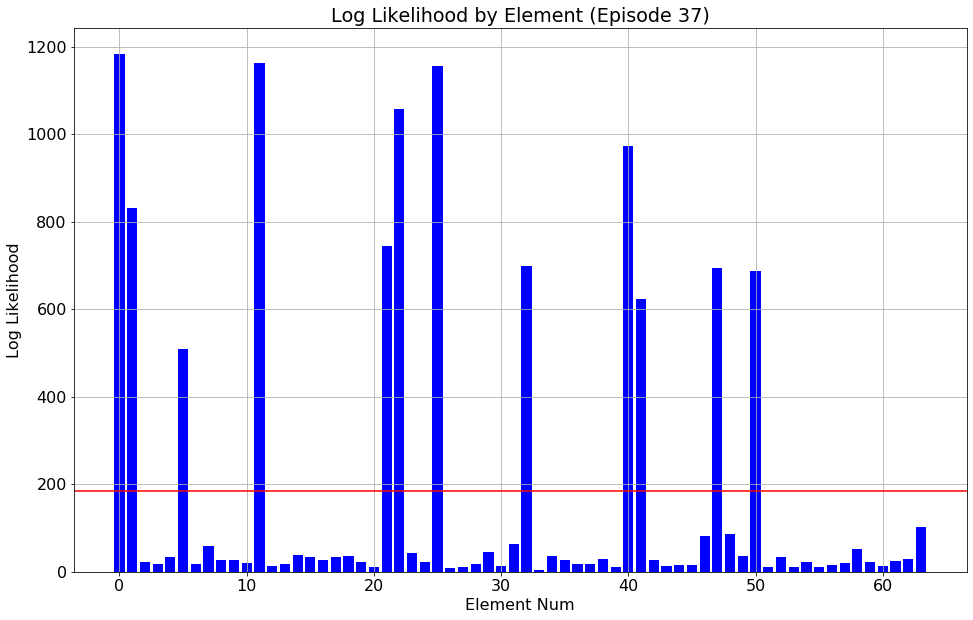

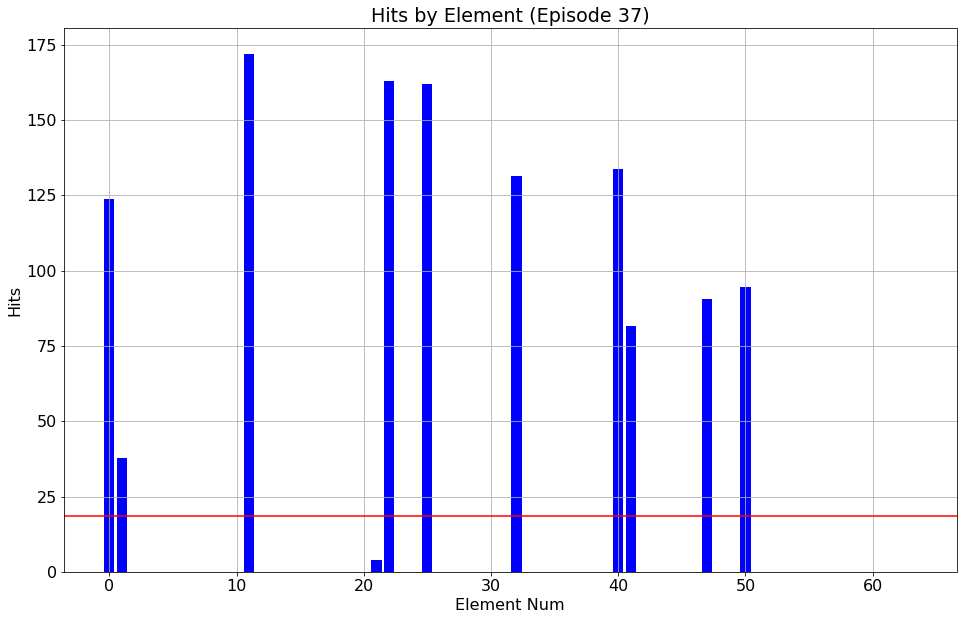


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 37: Epoch  148, Batch   9472
effective_learning_rate=1.221e-04, training_time 403 sec.
Train on 4096 samples
Epoch 149/152
4096/4096 [==============================] - 4s 968us/sample - loss: -5162.2447
Epoch 150/152
4096/4096 [==============================] - 2s 529us/sample - loss: -5251.9871
Epoch 151/152
4096/4096 [==============================] - 2s 540us/sample - loss: -5339.5675
Epoch 152/152
4096/4096 [==============================] - 2s 534us/sample - loss: -5425.2377
Adjusted element weight down on 12 candidate elements. Mean weight = 9.06e-01
                    \  All Elts : Bad Elts : Good Elts (11)
Geom Mean Resolution:    196.74 :   287.65 :    31.55 arc seconds
Geom Mean Thr

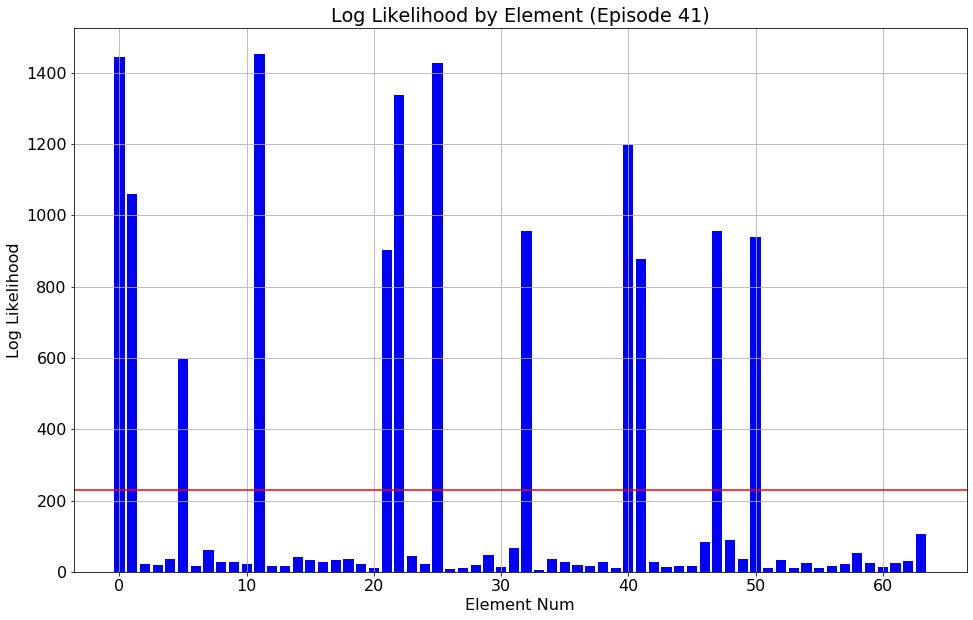

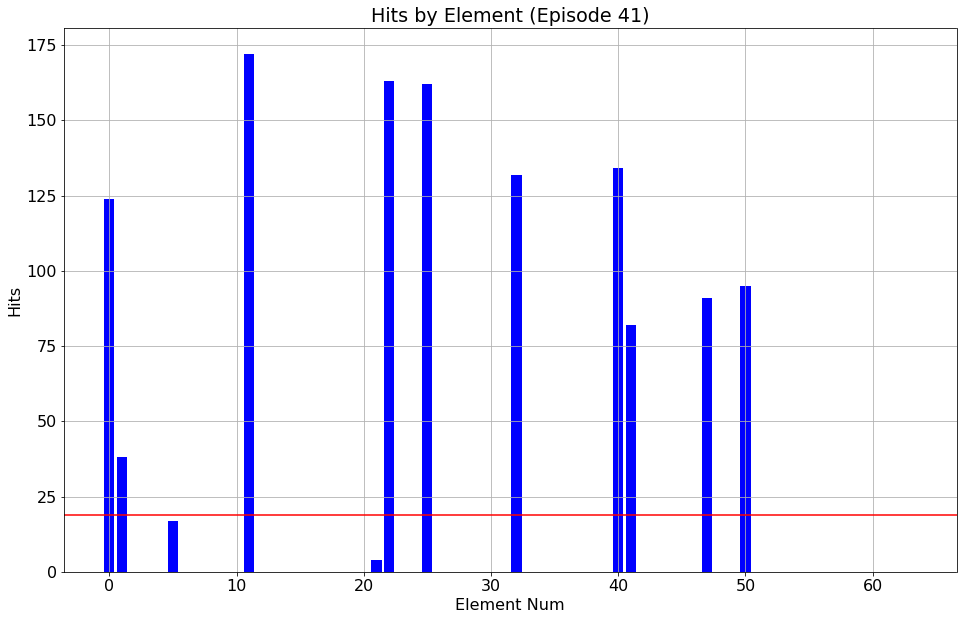


********************************************************************************
Round 6: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 41: Epoch  164, Batch  10496
effective_learning_rate=3.815e-06, training_time 443 sec.
Train on 4096 samples
Epoch 165/168
4096/4096 [==============================] - 6s 1ms/sample - loss: -6008.0167
Epoch 166/168
4096/4096 [==============================] - 3s 652us/sample - loss: -6139.6751
Epoch 167/168
4096/4096 [==============================] - 3s 637us/sample - loss: -6149.1216
Epoch 168/168
4096/4096 [==============================] - 3s 660us/sample - loss: -6157.8998
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (11)
Geom Mean Resolution:    174.58 :   283.54 :    

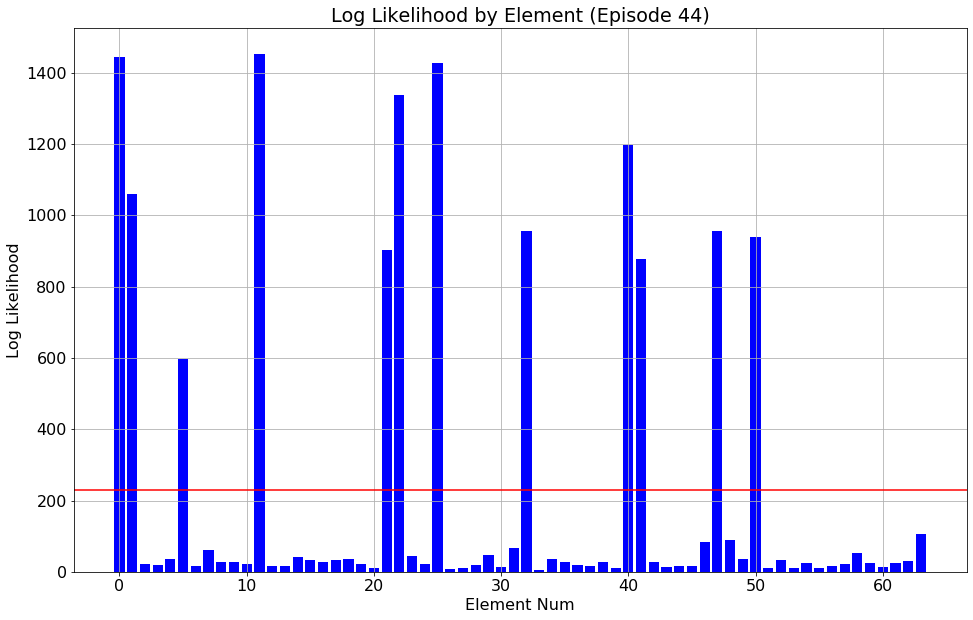

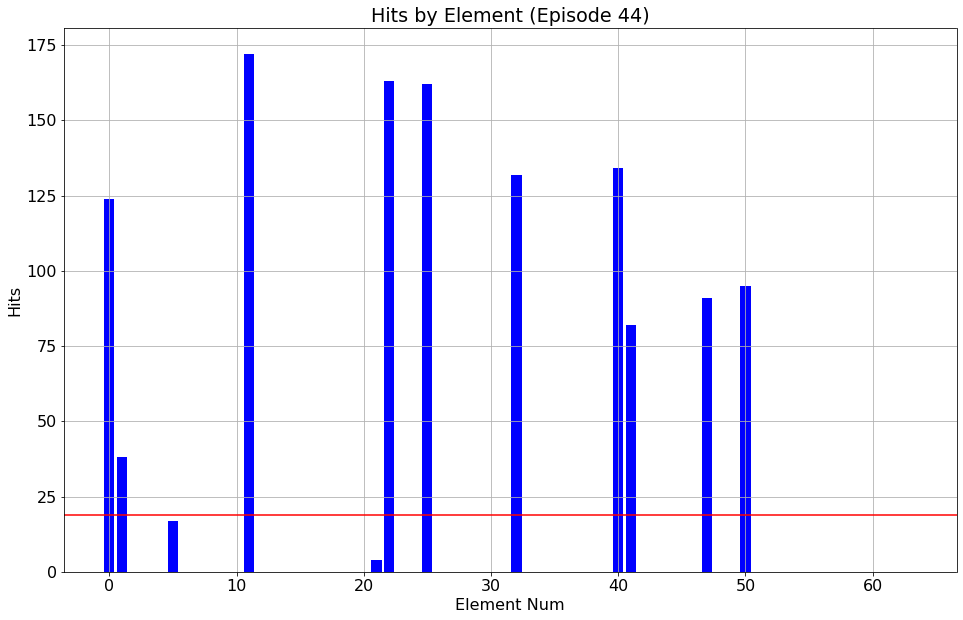


********************************************************************************
Round 7: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************
Applying learning_rate 3.81e-06 (2.0^-18.0) for adaptive training.

Training episode 44: Epoch  176, Batch  11264
effective_learning_rate=3.815e-06, training_time 484 sec.
Train on 4096 samples
Epoch 177/180
4096/4096 [==============================] - 5s 1ms/sample - loss: -5938.2540
Epoch 178/180
4096/4096 [==============================] - 3s 663us/sample - loss: -6068.4110
Epoch 179/180
4096/4096 [==============================] - 3s 652us/sample - loss: -6077.7326
Epoch 180/180
4096/4096 [==============================] - 3s 642us/sample - loss: -6086.4298
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
Increasing bad_episode_count to 1.
                    \  All Elts : Bad Elts : Good Elts (11)
Geom Mean Resolution:    174.58 :   283.54 :    1

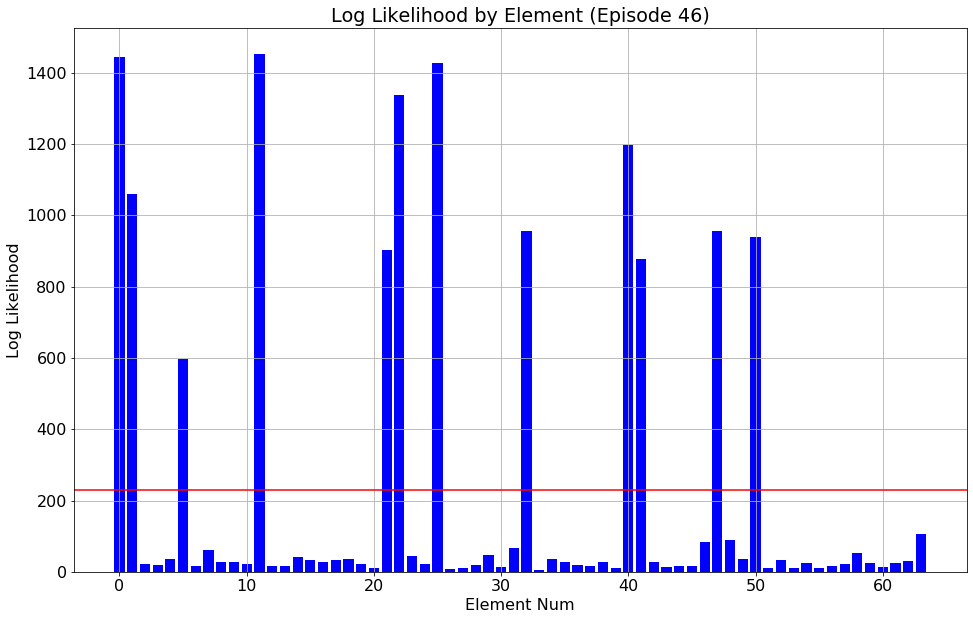

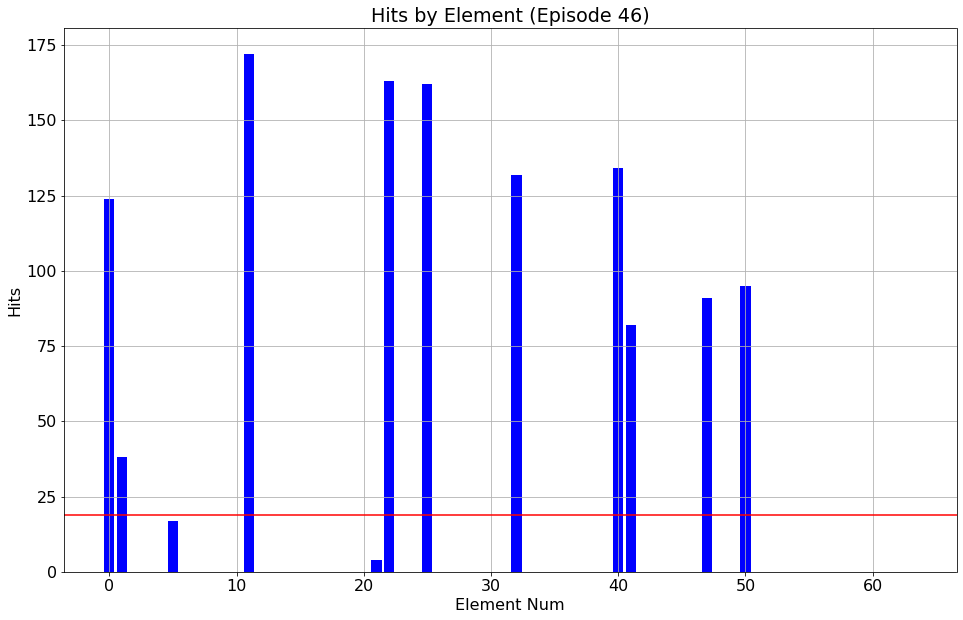

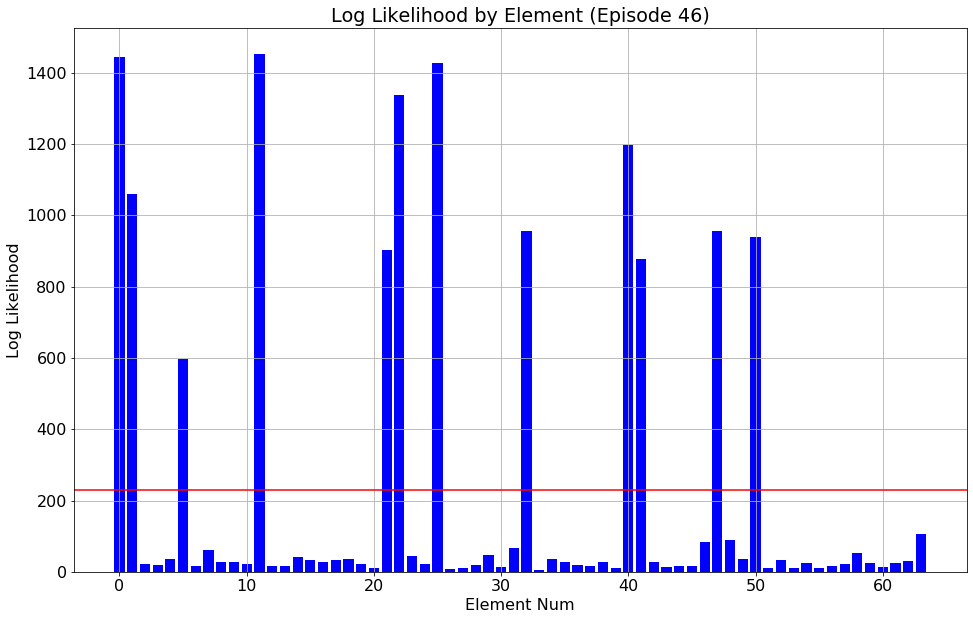

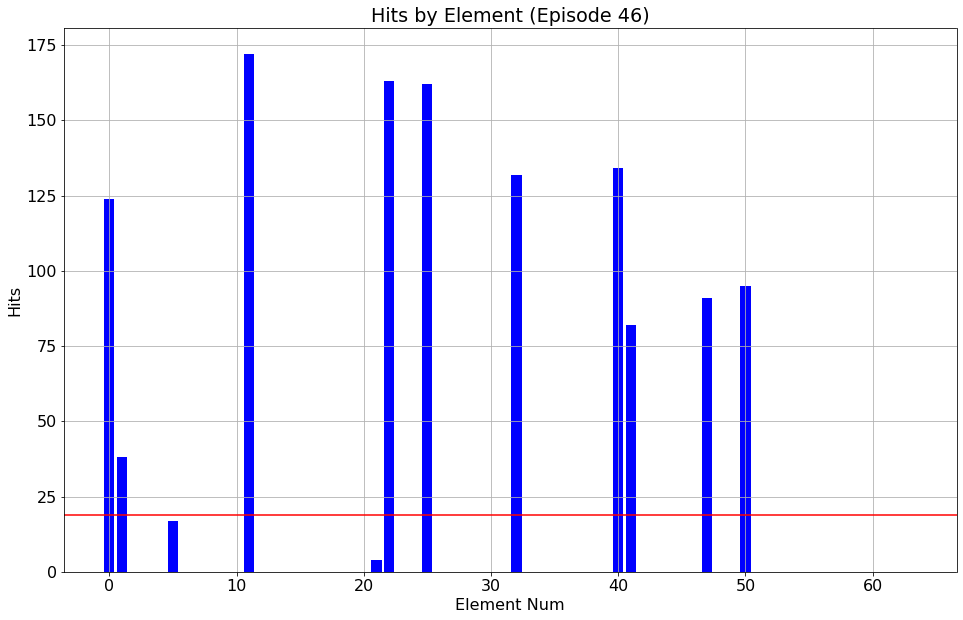

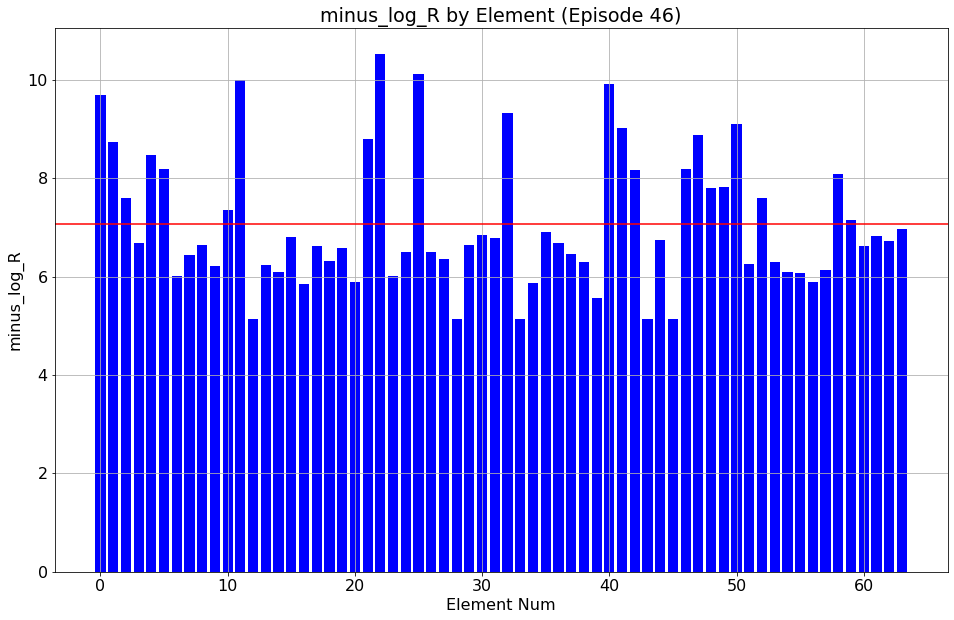

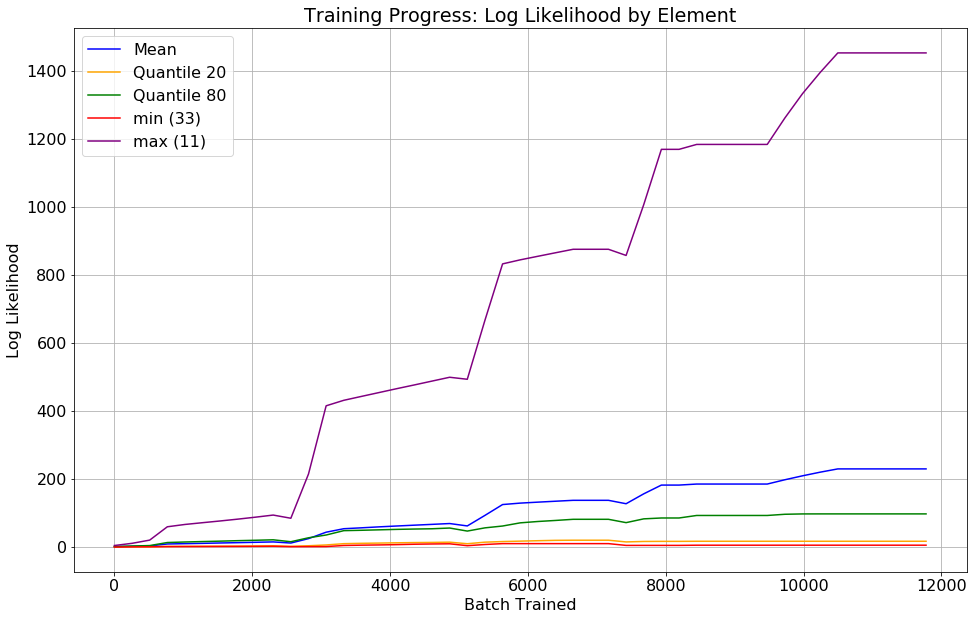

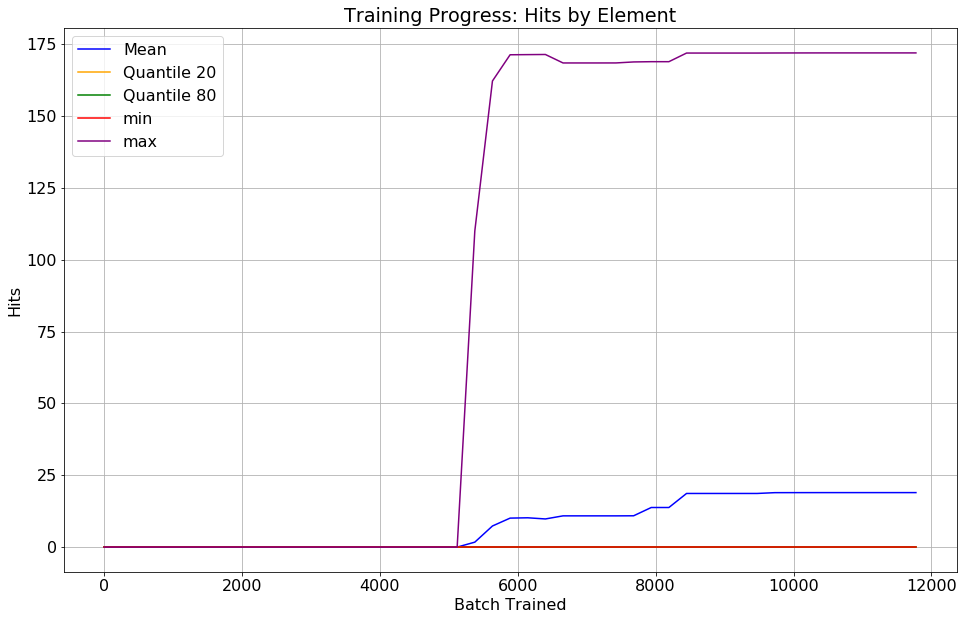

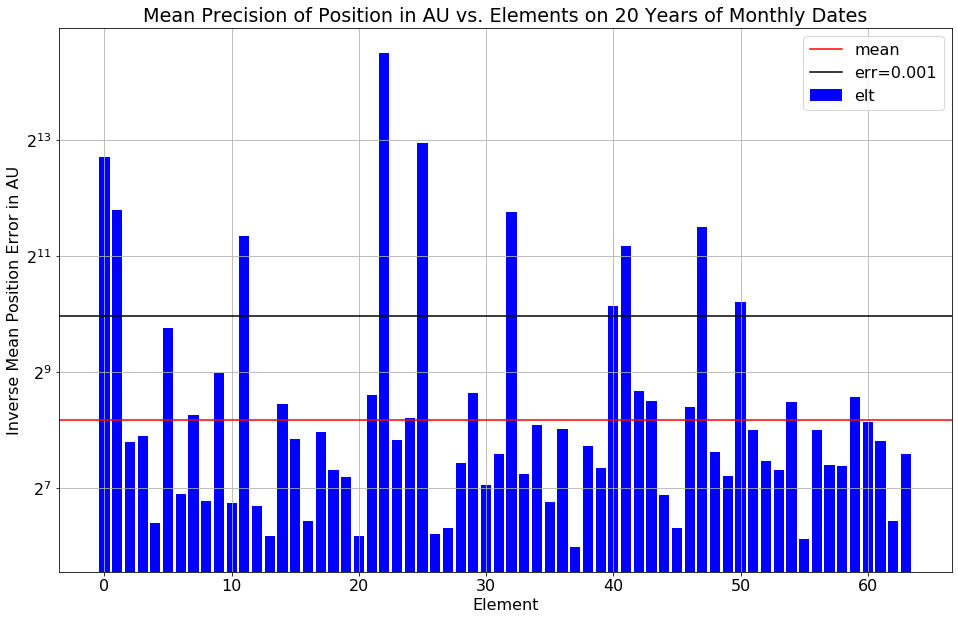

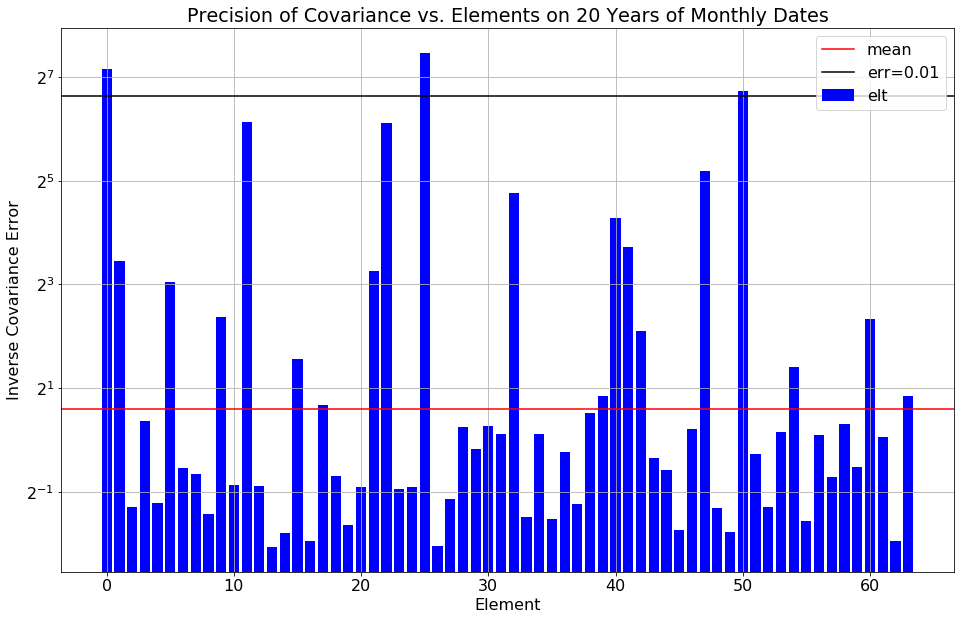

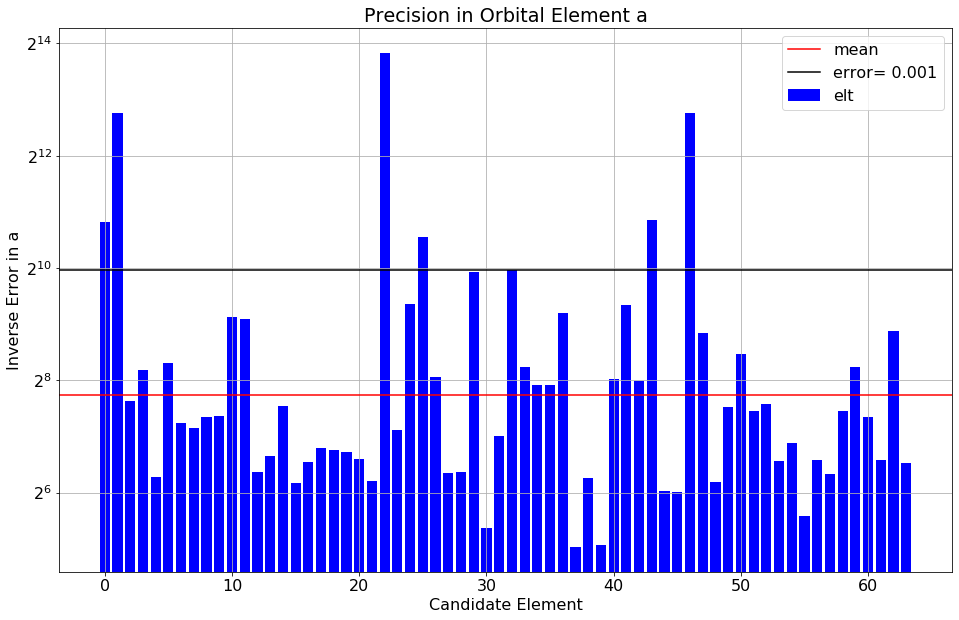

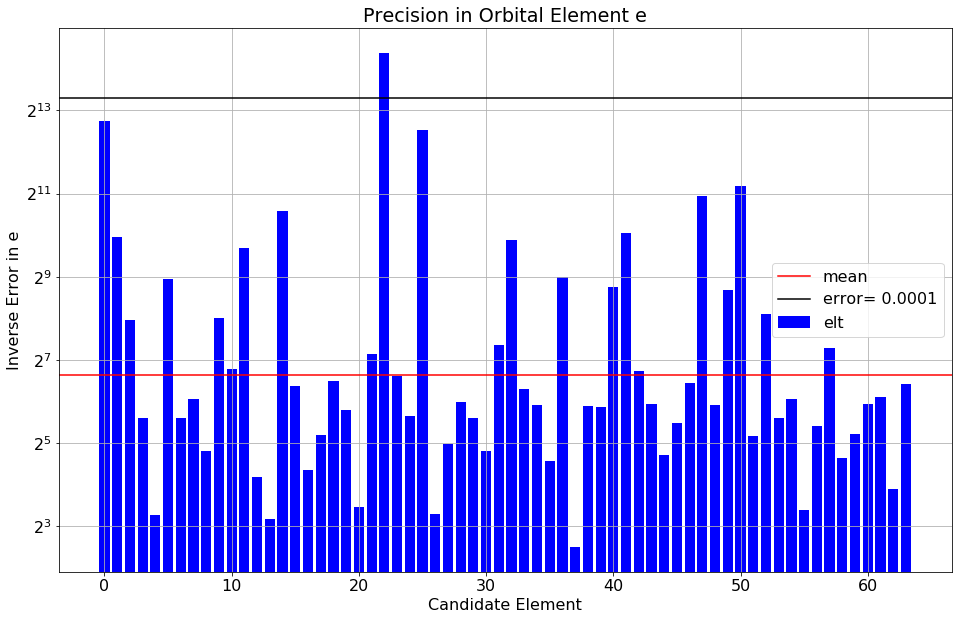

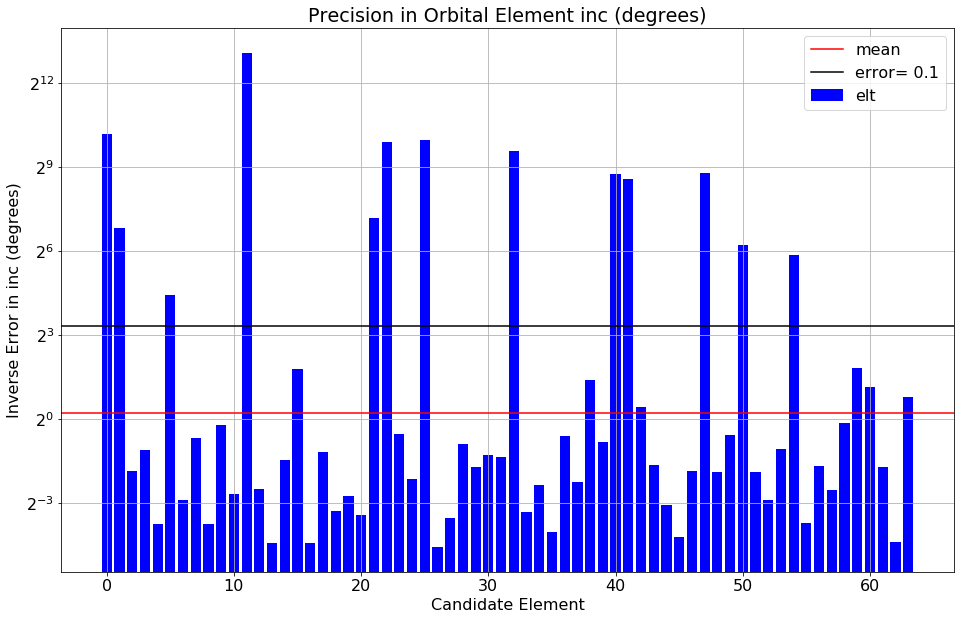

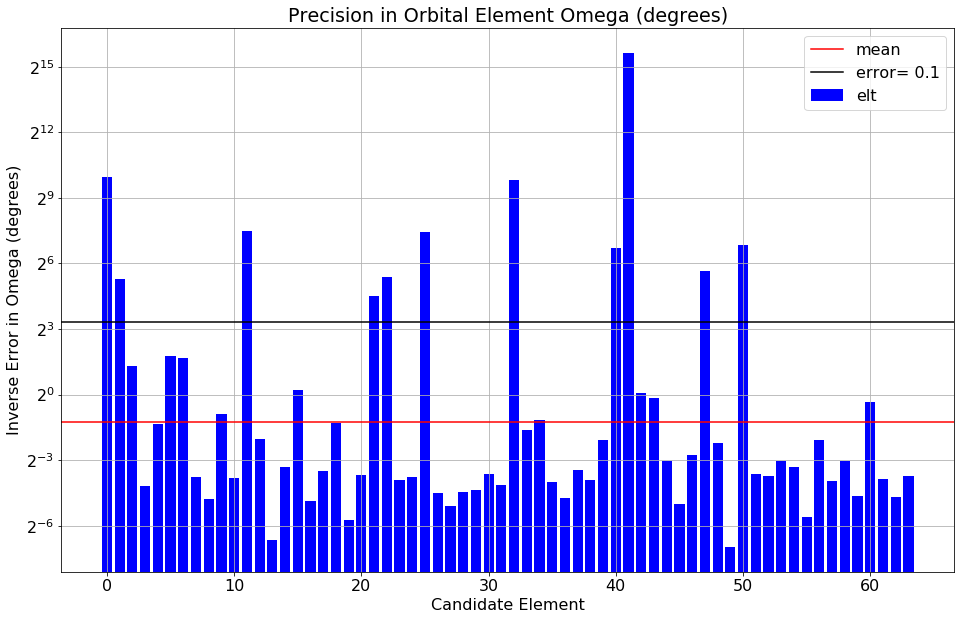

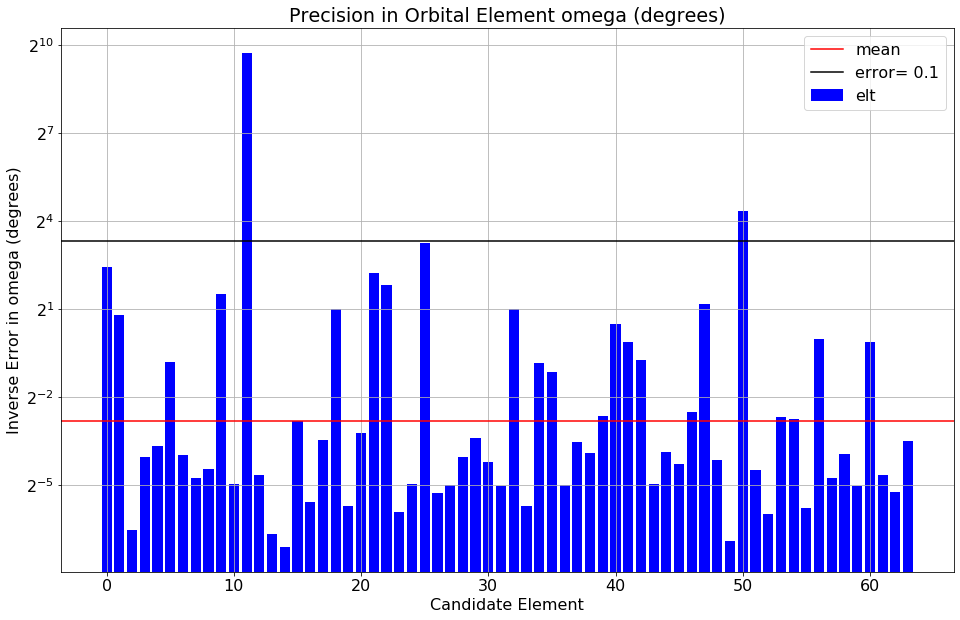

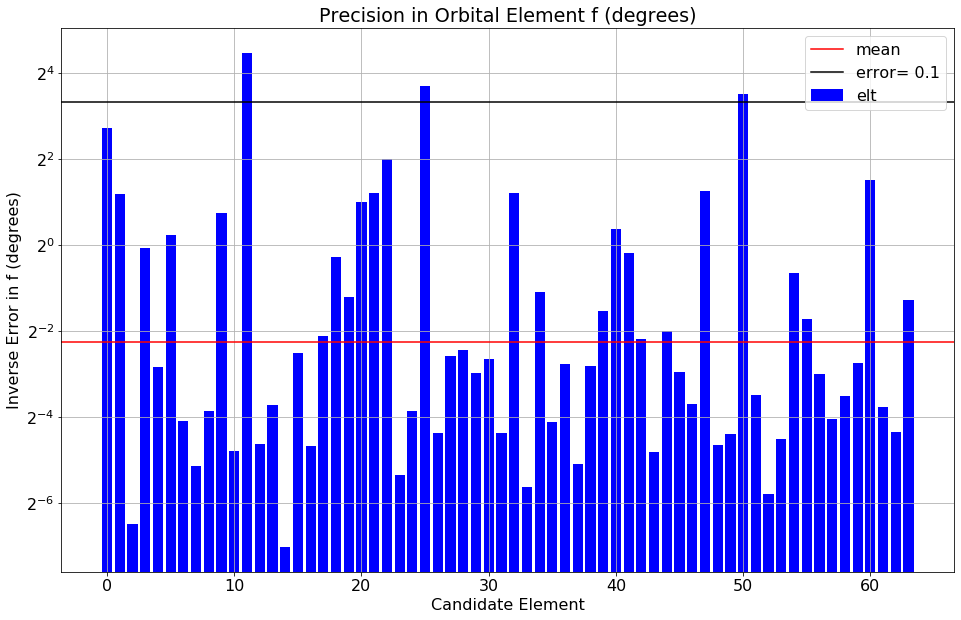

In [36]:
model.sieve()

In [37]:
model.report()


Good elements (hits >= 10):  11.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1113.25  : 110.00 :    20.99 :  2400.00
Mean Bad :    45.28  :   0.08 :   387.74 :  2400.00
Mean     :   228.84  :  18.97 :   324.70 :  2400.00
Median   :    27.22  :   0.00 :   263.07 :  2400.00
GeoMean  :    48.21  :   1.24 :   176.46 :  2401.00
Min      :     4.45  :   0.00 :     5.54 :  2400.00
Max      :  1452.40  : 172.00 :  1200.00 :  2400.00
Trained for 11776 batches over 184 epochs and 46 episodes (elapsed time 513 seconds).


## Distance vs. Nearest Asteroid for Fitted Elements

In [38]:
_ = model.nearest_ast()

In [39]:
model.report()


Good elements (hits >= 10):  11.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1113.26  : 110.00 :    20.99 :  2400.00
Mean Bad :    45.28  :   0.08 :   387.74 :  2400.00
Mean     :   228.84  :  18.97 :   324.70 :  2400.00
Median   :    27.22  :   0.00 :   263.07 :  2400.00
GeoMean  :    48.21  :   1.24 :   176.46 :  2401.00
Min      :     4.45  :   0.00 :     5.54 :  2400.00
Max      :  1452.40  : 172.00 :  1200.00 :  2400.00
Trained for 11776 batches over 184 epochs and 46 episodes (elapsed time 513 seconds).


In [40]:
# model.save_state()

In [41]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 11 asteroids.
Mean on converged asteroids:
Number of hits         : 109.96
Resolution in arc sec  : 20.99
GeoMean Distance in AU : 3.17e-04
Covariance norm        : 2.57e-02


In [42]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
11,9936,1452.396973,171.988617,9.353982,2399.999756,9936,0.000386,0.014296
22,9229,1338.364380,162.984680,5.538219,2399.999756,9229,0.000043,0.014348
25,203722,1426.508057,161.993027,8.294964,2399.999756,203722,0.000127,0.005648
40,31539,1198.540405,133.983978,10.199452,2399.999756,31539,0.000881,0.051209
32,19794,955.573486,131.889969,18.177172,2399.999756,19794,0.000289,0.036948
0,51921,1445.037109,123.981842,12.836143,2399.999756,51921,0.000150,0.006968
50,6455,938.554199,94.943497,23.128164,2399.999756,6455,0.000848,0.009391
47,733,957.261475,90.955696,28.474575,2399.999756,733,0.000345,0.027273
41,3426,876.529114,81.914848,24.931597,2399.999756,3426,0.000434,0.075625
1,59244,1058.773071,37.973412,33.012936,2399.999756,59244,0.000283,0.091853


In [43]:
# # Review fitted elements including nearest asteroid
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,2.669857,0.217507,0.499539,4.699686,2.447523,-1.130830,58600.0,194.901077,0.000062,...,0.666667,2399.999756,1445.037109,123.981842,622.0,14.950818,3.103824,51921,0.000150,0.006968
1,59244,2.634582,0.263507,0.464890,5.737846,1.777059,-1.609091,58600.0,189.975616,0.000160,...,0.666667,2399.999756,1058.773071,37.973412,536.0,14.949151,3.098156,59244,0.000283,0.091853
2,15786,1.919552,0.045395,0.380058,6.132865,0.780615,-1.247157,58600.0,17.836246,0.000499,...,0.666667,2399.999756,21.702948,0.000000,378.0,14.911119,3.140766,425432,0.004486,2.438361
3,3904,2.788749,0.137892,0.256108,5.513758,2.177979,-1.373426,58600.0,32.859055,0.001259,...,0.666667,2399.999756,18.966824,0.000000,364.0,17.377733,3.127090,258552,0.004162,0.781159
4,142999,2.521709,0.183627,0.503989,0.210559,0.936103,-1.336856,58600.0,15.082423,0.000207,...,0.666667,2399.999756,34.758297,0.000000,419.0,17.178854,3.120975,451765,0.011836,2.323180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.365147,0.078279,0.119193,0.118479,2.848246,-3.016829,58600.0,39.522526,0.000784,...,0.666667,2399.999756,23.310322,0.000000,1178.0,17.531305,3.043172,448447,0.002636,1.433551
60,134815,2.618888,0.157131,0.521907,0.294921,0.664502,-0.951712,58600.0,25.453268,0.001339,...,0.666667,2399.999756,14.292083,0.000000,246.0,18.030962,3.168324,134815,0.003519,0.198363
61,27860,2.598665,0.097617,0.194385,5.532492,3.259200,3.967742,58600.0,51.618568,0.001080,...,0.666667,2399.999756,24.970537,0.000000,987.0,18.149839,3.162179,1047580,0.004419,0.963102
62,85937,2.193752,0.192435,0.435285,5.235367,3.115437,3.985428,58600.0,41.874580,0.001207,...,0.666667,2399.999756,29.600595,0.000000,384.0,16.304375,3.230548,45947,0.011540,3.858137


In [44]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
22,9229,162.984619,5.538219,2399.999756,1338.364380,162.984680,0.000043,0.014348
25,203722,161.993088,8.294964,2399.999756,1426.508057,161.993027,0.000127,0.005648
11,9936,172.988297,9.353982,2399.999756,1452.396973,171.988617,0.000386,0.014296
40,31539,153.979019,10.199452,2399.999756,1198.540405,133.983978,0.000881,0.051209
0,51921,194.901077,12.836143,2399.999756,1445.037109,123.981842,0.000150,0.006968
32,19794,159.866165,18.177172,2399.999756,955.573486,131.889969,0.000289,0.036948
50,6455,150.763580,23.128164,2399.999756,938.554199,94.943497,0.000848,0.009391
41,3426,152.834625,24.931597,2399.999756,876.529114,81.914848,0.000434,0.075625
47,733,149.620865,28.474575,2399.999756,957.261475,90.955696,0.000345,0.027273
21,77774,164.712494,31.055326,2399.999756,901.974792,3.997202,0.002552,0.104740


In [45]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

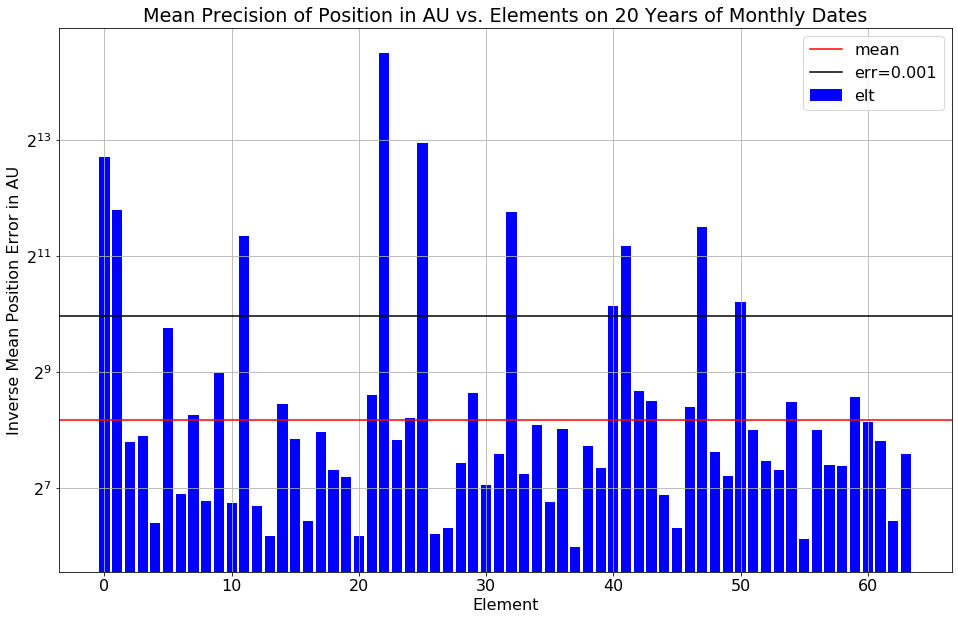

In [46]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

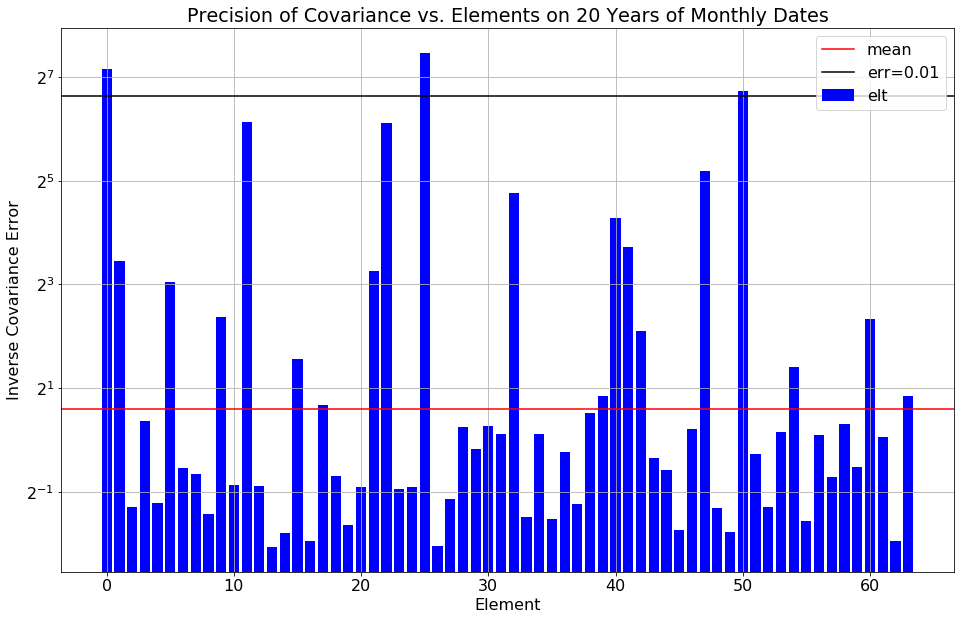

In [47]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

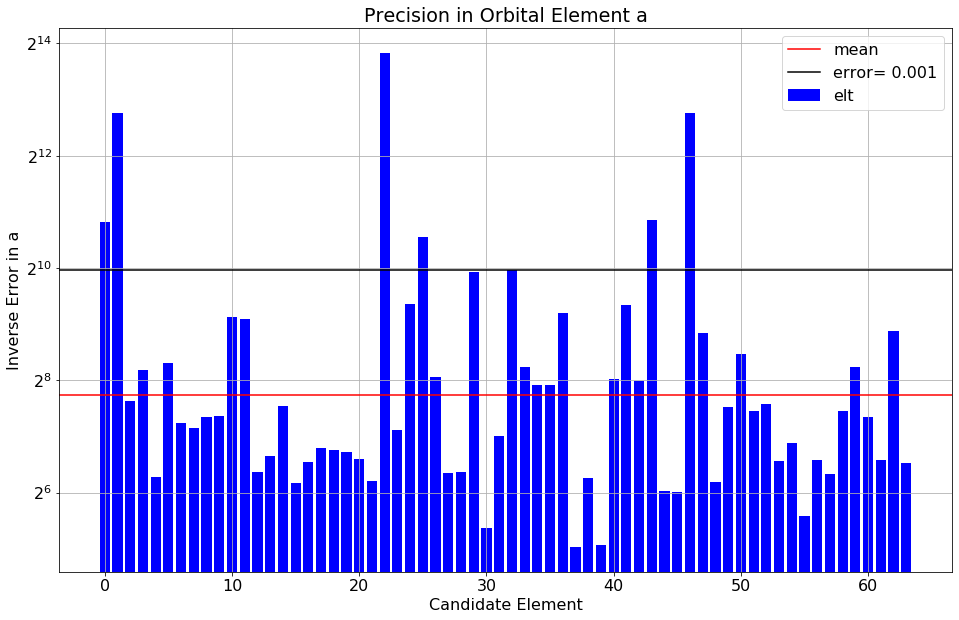

In [48]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

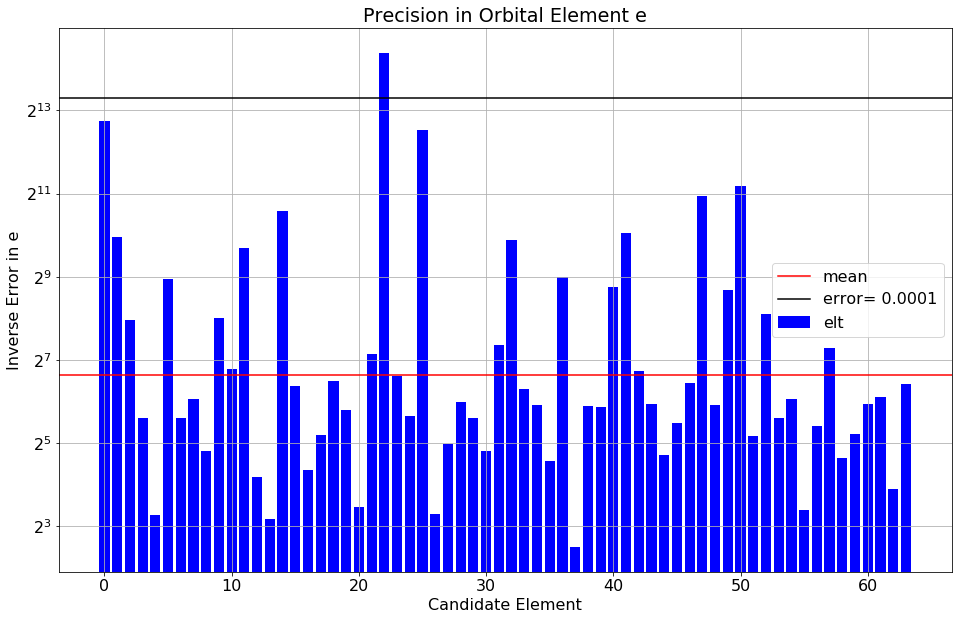

In [49]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

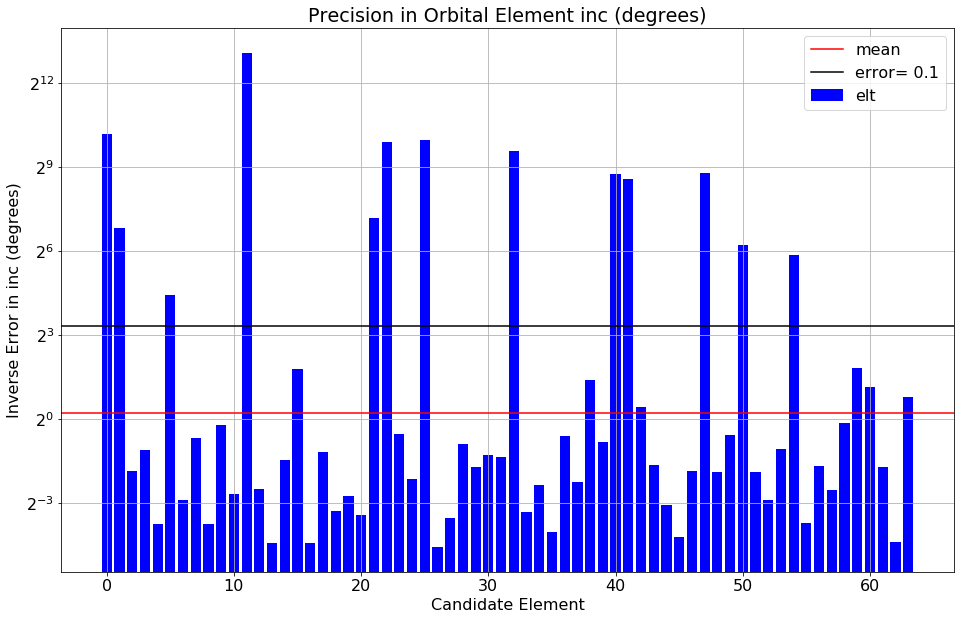

In [50]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

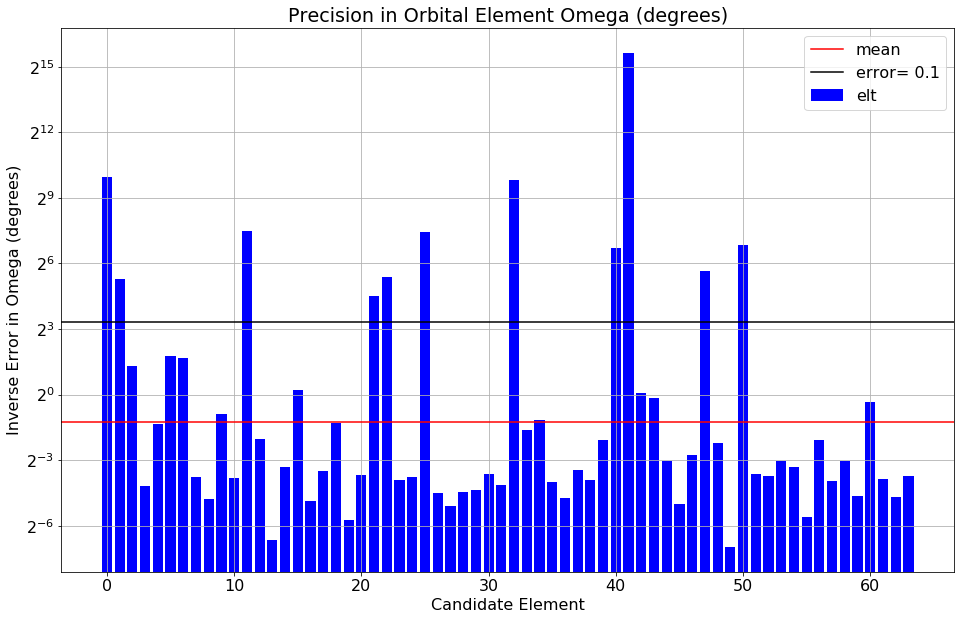

In [51]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

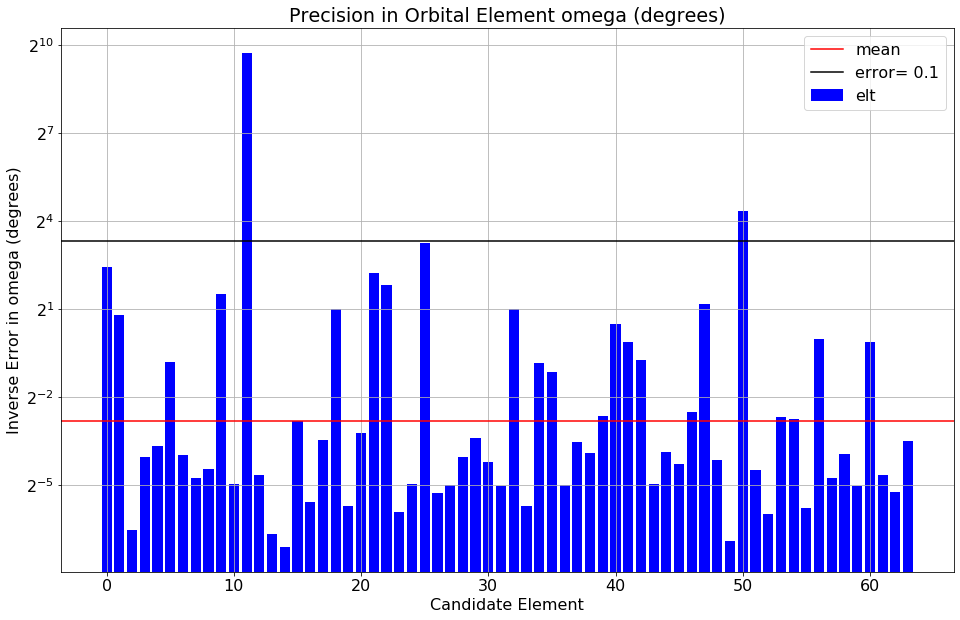

In [52]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

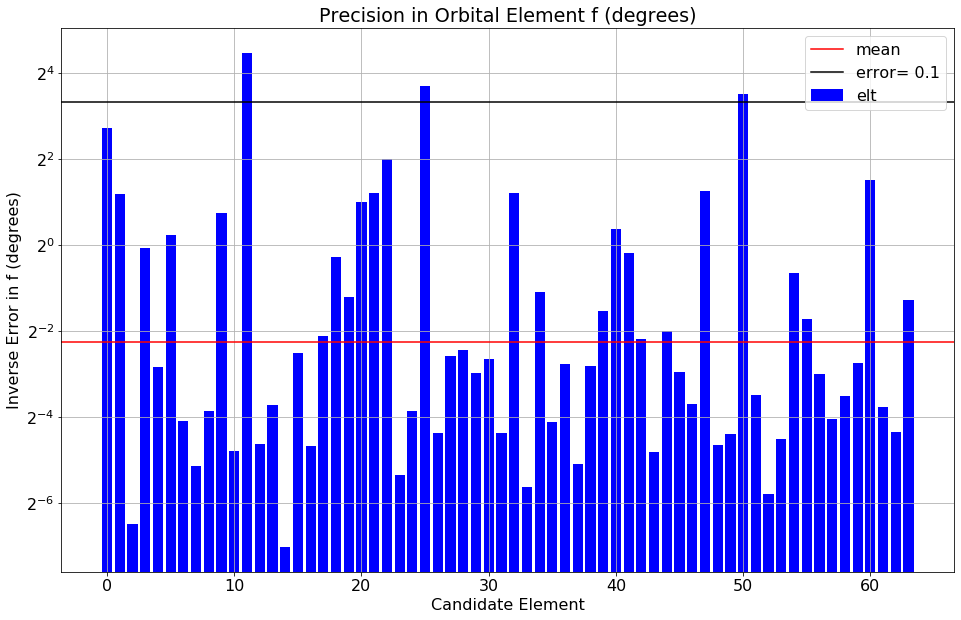

In [53]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)

In [54]:
model.candidates_df()

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,weight_joint,weight_element,weight_mixture
0,51921,2.669857,0.217507,0.499539,4.699686,2.447523,-1.130830,58600.0,194.901077,0.000062,...,0.666667,2399.999756,1445.039307,123.981842,622.0,14.950818,3.103824,0.25,1.0,1.0000
1,59244,2.634582,0.263507,0.464890,5.737846,1.777059,-1.609091,58600.0,189.975616,0.000160,...,0.666667,2399.999756,1058.772705,37.973412,536.0,14.949151,3.098156,0.25,1.0,1.0000
2,15786,1.919552,0.045395,0.380058,6.132865,0.780615,-1.247157,58600.0,17.836246,0.000499,...,0.666667,2399.999756,21.703100,0.000000,378.0,14.911119,3.140766,0.25,1.0,0.2500
3,3904,2.788749,0.137892,0.256108,5.513758,2.177979,-1.373426,58600.0,32.859055,0.001259,...,0.666667,2399.999756,18.966801,0.000000,364.0,17.377733,3.127090,0.25,1.0,0.5000
4,142999,2.521709,0.183627,0.503989,0.210559,0.936103,-1.336856,58600.0,15.082423,0.000207,...,0.666667,2399.999756,34.758327,0.000000,419.0,17.178854,3.120975,0.25,1.0,0.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.365147,0.078279,0.119193,0.118479,2.848246,-3.016829,58600.0,39.522526,0.000784,...,0.666667,2399.999756,23.310308,0.000000,1178.0,17.531305,3.043172,0.25,1.0,1.0000
60,134815,2.618888,0.157131,0.521907,0.294921,0.664502,-0.951712,58600.0,25.453268,0.001339,...,0.666667,2399.999756,14.292073,0.000000,246.0,18.030962,3.168324,0.25,1.0,0.0625
61,27860,2.598665,0.097617,0.194385,5.532492,3.259200,3.967742,58600.0,51.618568,0.001080,...,0.666667,2399.999756,24.970678,0.000000,987.0,18.149839,3.162179,0.25,1.0,0.2500
62,85937,2.193752,0.192435,0.435285,5.235367,3.115437,3.985428,58600.0,41.874580,0.001207,...,0.666667,2399.999756,29.600626,0.000000,384.0,16.304375,3.230548,0.25,1.0,0.0625
